# Clasificación multiclase

## Introduction

En este ejercicio se implementa la regresion one-vs-all y una red neuronal para reconocimiento de digitos.

Antes de empezar la ejecución de las partes de codigo correspondienters a los ejercicios, se requiere importar todas las librerias necesarias.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
# utilizado para la manipulación de directorios y rutas
import os

import pandas as pd

# Cálculo científico y vectorial para python
import numpy as np

# Libreria para graficos
from matplotlib import pyplot

# Modulo de optimizacion en scipy
from scipy import optimize

# le dice a matplotlib que incruste gráficos en el cuaderno
%matplotlib inline

## 1 Clasificación multiclase



La primera parte del ejercicio, extenderá la implementación anterior de la regresión logística y la aplicará a la clasificación de uno contra todos (one vs all).

### 1.1 Dataset





In [2]:
# La entrada es de 19 elemento contando con x0
input_layer_size  = 19
# El numero de etiquetas de mi dataset es de 5
num_labels = 5

#  datos de entrenamiento almacenados en los arreglos X, y
data = pd.read_csv('C:/Users/Manuel/Desktop/Maching learning/Nueva carpeta/Reuters Newswire Topics Dataset.csv', delimiter=',')

# Dividir los datos en características (X) y objetivo (y)
X = data.iloc[:, :-1]  # Todas las columnas excepto la última
y = data.iloc[:, -1]   # La última columna

# Número de ejemplos de entrenamiento
m = y.size

In [5]:
#print(X[0,:])
#print(y)
data.head()


,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11,Feature_12,Feature_13,Feature_14,Feature_15,Feature_16,Feature_17,Feature_18,Feature_19,Class
0,0.989,0.933,7.066,7.578,6.594,2.849,4.931,72.072,24.617,142.936,74.081,105.701,54.521,32.617,121.537,25.751,144.337,69.595,41.101,1.0
1,0.997,0.478,7.662,8.635,3.066,4.509,1.436,85.700,39.412,37.528,117.419,87.170,108.446,56.649,71.172,113.226,101.245,60.219,118.244,0.0
2,0.347,0.631,5.491,0.754,0.020,7.220,8.970,40.162,20.028,141.028,63.459,63.072,100.683,67.985,146.706,126.889,30.212,77.758,97.303,4.0
3,0.191,0.138,8.315,8.823,1.375,1.894,6.507,95.557,114.442,21.842,100.862,112.891,28.602,94.809,93.514,106.238,85.042,135.045,46.371,2.0
4,0.822,0.587,9.642,3.389,7.036,0.379,8.303,37.211,92.917,90.042,48.364,104.354,56.836,49.982,143.241,22.332,115.821,116.677,65.306,0.0


In [6]:
print('cantidad de datos:')
print(data.shape)

cantidad de datos:
(34000, 20)


In [7]:
def  featureNormalize(X):
    X_norm = X.copy()
    mu = np.zeros(X.shape[1])
    sigma = np.zeros(X.shape[1])

    mu = np.mean(X, axis = 0)
    sigma = np.std(X, axis = 0)
    X_norm = (X - mu) / sigma

    return X_norm, mu, sigma

In [8]:
# llama featureNormalize con los datos cargados
X_norm, mu, sigma = featureNormalize(X)

In [9]:
# Configurar la matriz adecuadamente, y agregar una columna de unos que corresponde al termino de intercepción.
m, n = X.shape
# Agraga el termino de intercepción a A
X = np.concatenate([np.ones((m, 1)), X_norm], axis=1)
#X = X_norm
# X = np.concatenate([np.ones((m, 1)), X], axis=1)

### 1.2 Visualización de los datos


In [10]:
# Selecciona aleatoriamente 100 puntos de datos para mostrar
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]

# displayData(sel)

### 1.3 Vectorización de regresión logística

Se utilizará múltiples modelos de regresión logística uno contra todos para construir un clasificador de clases múltiples. Dado que hay 10 clases, deberá entrenar 10 clasificadores de regresión logística separados. Para que esta capacitación sea eficiente, es importante asegurarse de que el código esté bien vectorizado.

En esta sección, se implementará una versión vectorizada de regresión logística que no emplea ningún bucle "for".

Para probar la regresión logística vectorizada, se usara datos personalizados como se definen a continuación.

<a id="section1"></a>
#### 1.3.1 Vectorización de la funcion de costo



In [11]:
def sigmoid(z):
    """
    Calcula la sigmoide de z.
    """
    return 1.0 / (1.0 + np.exp(-z))

In [12]:
cost_history = []

def lrCostFunction(theta, X, y, lambda_):
    """
    Calcula el costo de usar theta como parámetro para la regresión logística regularizada y
    el gradiente del costo w.r.t. a los parámetros.

    Parametros
    ----------
    theta : array_like
        Parametro theta de la regresion logistica. Vector de la forma(shape) (n, ). n es el numero de caracteristicas
        incluida la intercepcion

    X : array_like
        Dataset con la forma(shape) (m x n). m es el numero de ejemplos, y n es el numero de
        caracteristicas (incluida la intercepcion).

    y : array_like
        El conjunto de etiquetas. Un vector con la forma (shape) (m, ). m es el numero de ejemplos

    lambda_ : float
        Parametro de regularización.

    Devuelve
    -------
    J : float
        El valor calculado para la funcion de costo regularizada.

    grad : array_like
        Un vector de la forma (shape) (n, ) que es el gradiente de la
        función de costo con respecto a theta, en los valores actuales de theta..
    """
#     alpha = 0.003
#     theta = theta.copy()
    # Inicializa algunos valores utiles
    m = y.size

    # convierte las etiquetas a valores enteros si son boleanos
    if y.dtype == bool:
        y = y.astype(int)

    J = 0
    grad = np.zeros(theta.shape)

    h = sigmoid(X.dot(theta.T))

    temp = theta
    temp[0] = 0

#     J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h)))
    J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h))) + (lambda_ / (2 * m)) * np.sum(np.square(temp))

    grad = (1 / m) * (h - y).dot(X)
#     theta = theta - (alpha / m) * (h - y).dot(X)
    grad = grad + (lambda_ / m) * temp

     # Añade el costo calculado a la lista de historial
    cost_history.append(J)

    return J, grad
#    return J, theta

#### 1.3.3 Vectorización regularizada de la regresión logística


</div>


<a id="section2"></a>
### 1.4 Clasificacion One-vs-all

<a id="oneVsAll"></a>

In [13]:
def oneVsAll(X, y, num_labels, lambda_):
    
    # algunas variables utiles
    m, n = X.shape

    all_theta = np.zeros((num_labels, n + 1))

    # Agrega unos a la matriz X
    X = np.concatenate([np.ones((m, 1)), X], axis=1)

    for c in np.arange(num_labels):
        initial_theta = np.zeros(n + 1)
        options = {'maxiter': 50}
        res = optimize.minimize(lrCostFunction,
                                initial_theta,
                                (X, (y == c), lambda_),
                                jac=True,
                                method='CG',
                                options=options)

        all_theta[c] = res.x

    return all_theta

In [27]:
lambda_ = 0.3
all_theta = oneVsAll(X, y, num_labels, lambda_)
print(all_theta.shape)

(5, 21)


In [28]:
print(all_theta)

[[-6.99713643e-01 -6.99572700e-01  6.32042762e-03 -6.12848928e-03
  -1.88821058e-02  1.00291106e-02  8.60487954e-03  3.88647938e-03
   2.68013040e-02 -1.72402977e-02 -3.20975855e-02 -2.72536515e-02
  -7.85801474e-04 -2.94595416e-02 -5.60819308e-03  1.44079728e-02
  -1.08526065e-02 -1.93775137e-02  3.54210711e-03  1.21094994e-02
  -6.21841027e-03]
 [-6.92733102e-01 -6.92595177e-01 -1.16333007e-02  1.09441084e-02
  -4.22372802e-03 -2.93426299e-04 -1.24138106e-02 -4.44555149e-03
  -5.77310772e-03 -1.00072388e-02  6.33206735e-03  1.05682950e-02
   2.03594051e-03  1.65725860e-03  1.82805982e-02 -5.73975002e-03
  -1.14859771e-02  1.22473433e-02  2.89235795e-03 -2.33794137e-03
   1.91012042e-02]
 [-6.93409296e-01 -6.93270481e-01  1.24502211e-02 -1.36416153e-02
   2.64769485e-03 -2.24308108e-03 -3.00455565e-04 -2.00828074e-03
  -3.59741732e-02 -1.54713877e-02  1.09494342e-02  7.64903532e-03
  -1.53196728e-02  6.30596021e-03  1.00257346e-02  3.25613977e-03
   1.43007159e-02  4.01347300e-03  2.0

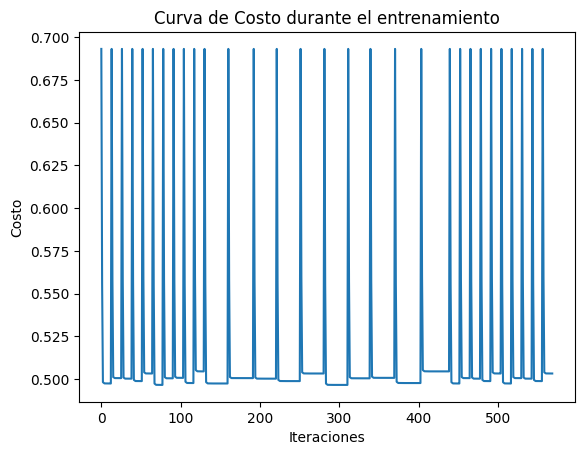

In [29]:
from matplotlib import pyplot as plt

plt.plot(cost_history)
plt.xlabel('Iteraciones')
plt.ylabel('Costo')
plt.title('Curva de Costo durante el entrenamiento')
plt.show()


<a id="section3"></a>
#### 1.4.1 Prediccion One-vs-all

Después de entrenar el clasificador de one-vs-all, se puede usarlo para predecir el dígito contenido en una imagen determinada. Para cada entrada, debe calcular la "probabilidad" de que pertenezca a cada clase utilizando los clasificadores de regresión logística entrenados. La función de predicción one-vs-all seleccionará la clase para la cual el clasificador de regresión logística correspondiente genera la probabilidad más alta y devolverá la etiqueta de clase (0, 1, ..., K-1) como la predicción para el ejemplo de entrada.

In [30]:
def predictOneVsAll(all_theta, X):
    """
    Devuelve un vector de predicciones para cada ejemplo en la matriz X.
    Tenga en cuenta que X contiene los ejemplos en filas.
    all_theta es una matriz donde la i-ésima fila es un vector theta de regresión logística entrenada para la i-ésima clase.
    Debe establecer p en un vector de valores de 0..K-1 (por ejemplo, p = [0, 2, 0, 1]
    predice clases 0, 2, 0, 1 para 4 ejemplos).

    Parametros
    ----------
    all_theta : array_like
        The trained parameters for logistic regression for each class.
        This is a matrix of shape (K x n+1) where K is number of classes
        and n is number of features without the bias.

    X : array_like
        Data points to predict their labels. This is a matrix of shape
        (m x n) where m is number of data points to predict, and n is number
        of features without the bias term. Note we add the bias term for X in
        this function.

    Devuelve
    -------
    p : array_like
        The predictions for each data point in X. This is a vector of shape (m, ).
    """

    m = X.shape[0];
    num_labels = all_theta.shape[0]

    p = np.zeros(m)

    # Add ones to the X data matrix
    X = np.concatenate([np.ones((m, 1)), X], axis=1)
    p = np.argmax(sigmoid(X.dot(all_theta.T)), axis = 1)

    return p

Una vez que haya terminado, se llama a la función `predictOneVsAll` usando el valor aprendido de $\theta$. Debería apreciarse que la precisión del conjunto de entrenamiento es de aproximadamente 95,1% (es decir, clasifica correctamente el 95,1% de los ejemplos del conjunto de entrenamiento).

In [31]:

#  Dividir los datos en conjuntos de entrenamiento y prueba
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#  Entrenar el clasificador
all_theta = oneVsAll(X_train, y_train, num_labels, lambda_)

# Precisión en el conjunto de entrenamiento
pred_train = predictOneVsAll(all_theta, X_train)
print('Precisión del conjunto de entrenamiento: {:.2f}%'.format(np.mean(pred_train == y_train) * 100))

# Precisión en el conjunto de prueba
pred_test = predictOneVsAll(all_theta, X_test)
print('Precisión del conjunto de prueba: {:.2f}%'.format(np.mean(pred_test == y_test) * 100))




Precisión del conjunto de entrenamiento: 21.49%
Precisión del conjunto de prueba: 20.56%
